# Project 2: Churn Prediction

**Type:** Classification | **Level:** Beginner

Predict customer churn based on usage patterns and demographics.

**Model:** Random Forest Classifier

**Dataset:** [Kaggle Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)

## 1. Setup & Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Data

In [ ]:
# Load the dataset
df = pd.read_csv('../data/Churn.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:\n{df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (7043, 21)

Column names:
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

First few rows:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3. Exploratory Data Analysis

Dataset Info:
Rows: 7043, Columns: 21

Data types:
object     18
int64       2
float64     1
Name: count, dtype: int64

Missing values: 0

Churn distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn percentage:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


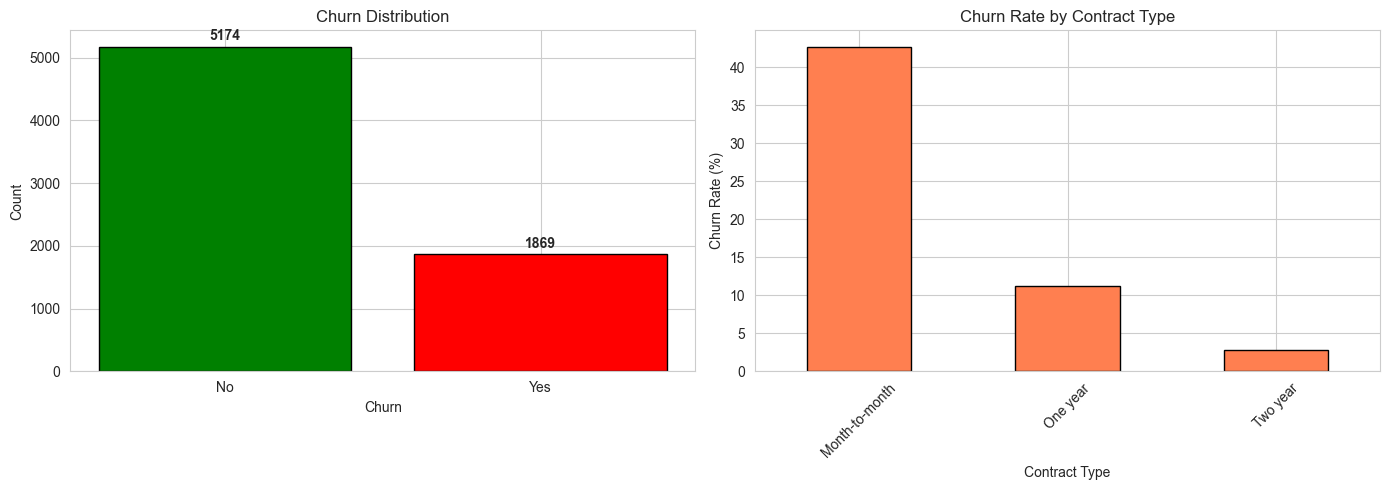

In [ ]:
# Basic info
print("Dataset Info:")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print(f"\nData types:\n{df.dtypes.value_counts()}")
print(f"\nMissing values: {df.isnull().sum().sum()}")
print(f"\nChurn distribution:")
print(df['Churn'].value_counts())
print(f"\nChurn percentage:")
print(df['Churn'].value_counts(normalize=True) * 100)

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Churn distribution
churn_counts = df['Churn'].value_counts()
axes[0].bar(churn_counts.index, churn_counts.values, color=['green', 'red'], edgecolor='black')
axes[0].set_title('Churn Distribution')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('Count')
for i, v in enumerate(churn_counts.values):
    axes[0].text(i, v + 100, str(v), ha='center', fontweight='bold')

# Churn by Contract type
churn_contract = pd.crosstab(df['Contract'], df['Churn'], normalize='index') * 100
churn_contract['Yes'].plot(kind='bar', ax=axes[1], color='coral', edgecolor='black')
axes[1].set_title('Churn Rate by Contract Type')
axes[1].set_xlabel('Contract Type')
axes[1].set_ylabel('Churn Rate (%)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [ ]:
# Prepare the data
df_processed = df.copy()

# Drop customerID (not useful for prediction)
df_processed = df_processed.drop('customerID', axis=1)

# Convert TotalCharges to numeric (has some empty strings)
df_processed['TotalCharges'] = pd.to_numeric(df_processed['TotalCharges'], errors='coerce')
df_processed['TotalCharges'] = df_processed['TotalCharges'].fillna(df_processed['TotalCharges'].median())

# Convert target to binary
df_processed['Churn'] = df_processed['Churn'].map({'Yes': 1, 'No': 0})

# Convert all categorical variables to dummy variables
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)

# Separate features and target
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nNumber of features: {X.shape[1]}")
print(f"\nTarget distribution:")
print(f"  No Churn (0): {(y==0).sum()}")
print(f"  Churn (1): {(y==1).sum()}")
print(f"\nSample features (first 5):")
print(X.columns.tolist()[:5])

Features shape: (7043, 30)
Target shape: (7043,)

Number of features: 30

Target distribution:
  No Churn (0): 5174
  Churn (1): 1869

Sample features (first 5):
['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'gender_Male']


## 5. Model Training

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nTraining set churn distribution:")
print(f"  No Churn: {(y_train==0).sum()}")
print(f"  Churn: {(y_train==1).sum()}")

# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
model.fit(X_train, y_train)

print("\nModel trained successfully!")

Training set size: 5634
Test set size: 1409

Training set churn distribution:
  No Churn: 4139
  Churn: 1495

Model trained successfully!


## 6. Model Evaluation

Model Performance:
Training Accuracy: 0.8647
Test Accuracy:     0.8070

Test Precision:    0.6700
Test Recall:       0.5374
Test F1-Score:     0.5964

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.84      0.90      0.87      1035
       Churn       0.67      0.54      0.60       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



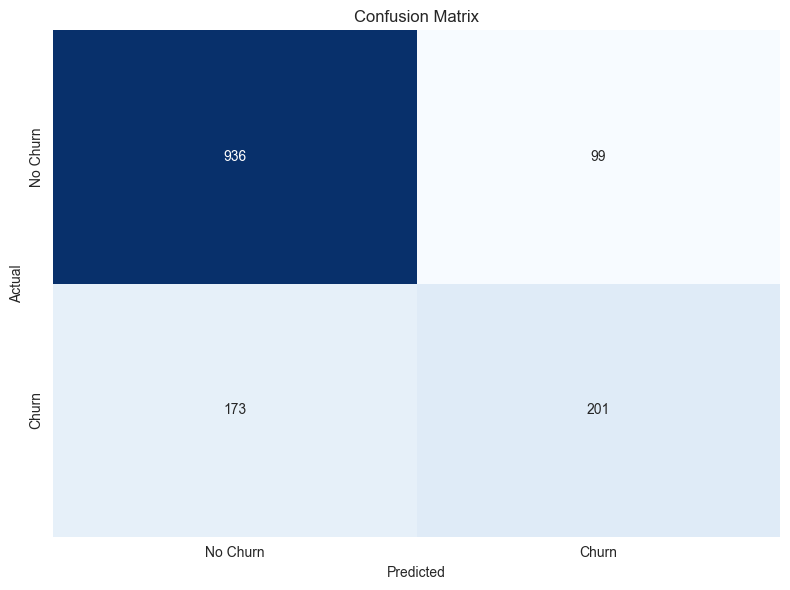

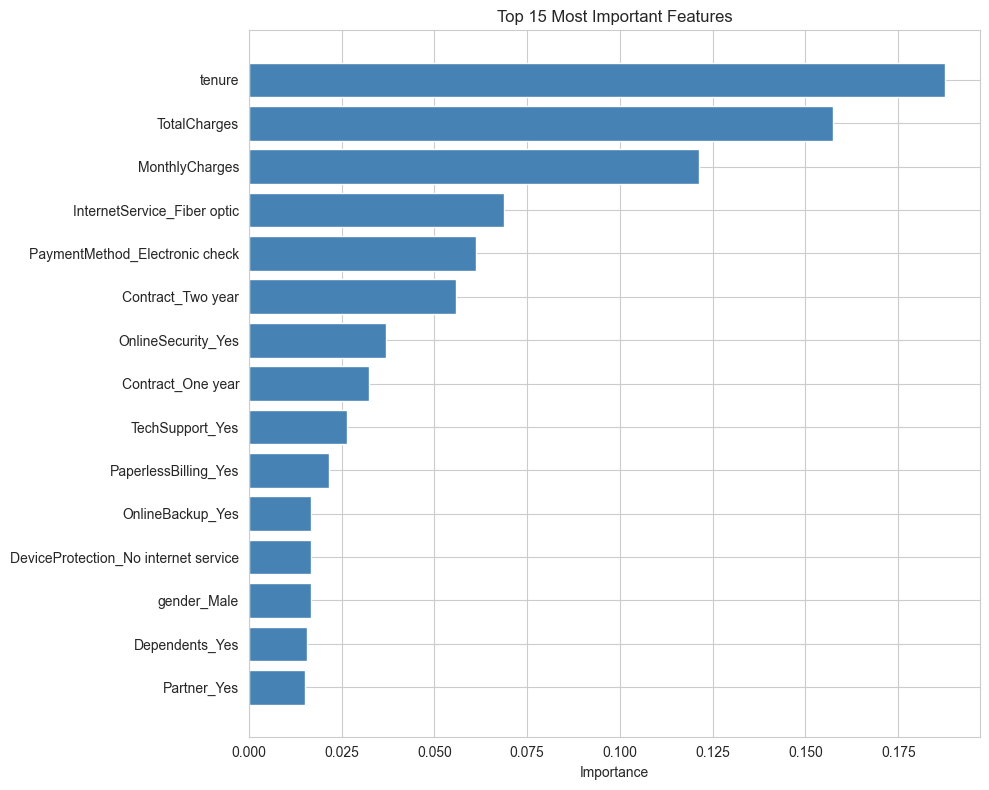

In [ ]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate metrics
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("Model Performance:")
print("="*50)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:     {test_acc:.4f}")
print(f"\nTest Precision:    {test_precision:.4f}")
print(f"Test Recall:       {test_recall:.4f}")
print(f"Test F1-Score:     {test_f1:.4f}")

print("\n" + "="*50)
print("Classification Report:")
print("="*50)
print(classification_report(y_test, y_test_pred, target_names=['No Churn', 'Churn']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Feature importance (top 15)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_importance)), feature_importance['importance'], color='steelblue')
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 7. Save Model

In [ ]:
# Save the trained model
model_path = '../models/churn_prediction_model.pkl'
joblib.dump(model, model_path)
print(f"✓ Model saved to: {model_path}")

# Save feature names and preprocessing info
preprocessing_data = {
    'feature_names': X.columns.tolist(),
    'categorical_columns': categorical_cols
}
preprocessing_path = '../models/churn_preprocessing.pkl'
joblib.dump(preprocessing_data, preprocessing_path)
print(f"✓ Preprocessing info saved to: {preprocessing_path}")

print("\n" + "="*50)
print("Model training complete!")
print("="*50)
print(f"\nModel Accuracy: {test_acc:.2%}")
print(f"Model F1-Score: {test_f1:.4f}")
print("\nTo use the model later:")
print("  model = joblib.load('../models/churn_prediction_model.pkl')")
print("  prediction = model.predict(new_data)")

✓ Model saved to: ../models/churn_prediction_model.pkl
✓ Preprocessing info saved to: ../models/churn_preprocessing.pkl

Model training complete!

Model Accuracy: 80.70%
Model F1-Score: 0.5964

To use the model later:
  model = joblib.load('../models/churn_prediction_model.pkl')
  prediction = model.predict(new_data)
